In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


In [2]:
# Set the environment variable to avoid the KMeans memory leak issue on Windows
os.environ["OMP_NUM_THREADS"] = "1"
# Suppress specific KMeans warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


In [3]:
def find_optimal_clusters(X_scaled, max_clusters=10):
    silhouette_scores = []
    ch_scores = []
    db_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
        ch_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))
        db_scores.append(davies_bouldin_score(X_scaled, cluster_labels))
    
    # Plot evaluation metrics
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.plot(range(2, max_clusters + 1), silhouette_scores)
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    
    plt.subplot(132)
    plt.plot(range(2, max_clusters + 1), ch_scores)
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    
    plt.subplot(133)
    plt.plot(range(2, max_clusters + 1), db_scores)
    plt.title('Davies-Bouldin Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    
    plt.tight_layout()
    plt.savefig('clustering_metrics.png')
    
    # Print all scores
    print("\nClustering Evaluation Scores:")
    for k in range(2, max_clusters + 1):
        print(f"\nNumber of clusters: {k}")
        print(f"Silhouette Score: {silhouette_scores[k-2]:.4f}")
        print(f"Calinski-Harabasz Score: {ch_scores[k-2]:.4f}")
        print(f"Davies-Bouldin Score: {db_scores[k-2]:.4f}")
    
    # Return optimal number of clusters (based on silhouette score)
    optimal_k = np.argmax(silhouette_scores) + 2
    print(f"\nOptimal number of clusters based on Silhouette Score: {optimal_k}")
    return optimal_k


In [4]:
def plot_clusters(X_scaled, cluster_labels, centers):
    # Create scatter plot of first two features
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidth=3, label='Centroids')
    plt.title('Cluster Assignments (First Two Features)')
    plt.xlabel('Feature 1 (Standardized)')
    plt.ylabel('Feature 2 (Standardized)')
    plt.colorbar(scatter)
    plt.legend()
    plt.savefig('cluster_visualization.png')
    plt.close()


In [5]:
def evaluate_kmeans():
    # Load all data
    data = pd.concat([ 
        pd.read_csv('train.csv'),
        pd.read_csv('train-valid.csv'),
        pd.read_csv('test.csv')
    ])
    
    # Separate features and true labels
    X = data.iloc[:, :-1].values
    true_labels = data.iloc[:, -1].values
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find optimal number of clusters
    optimal_clusters = find_optimal_clusters(X_scaled)
    
    # Fit KMeans with optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Plot clusters
    plot_clusters(X_scaled, cluster_labels, kmeans.cluster_centers_)
    
    # Calculate external validation metrics
    ari_score = adjusted_rand_score(true_labels, cluster_labels)
    nmi_score = normalized_mutual_info_score(true_labels, cluster_labels)
    
    print("\nExternal Validation Metrics (comparing with true labels):")
    print(f"Adjusted Rand Index: {ari_score:.4f}")
    print(f"Normalized Mutual Information: {nmi_score:.4f}")
    
    # Print cluster sizes
    unique_clusters, cluster_sizes = np.unique(cluster_labels, return_counts=True)
    print("\nCluster Sizes:")
    for cluster, size in zip(unique_clusters, cluster_sizes):
        print(f"Cluster {cluster}: {size} samples")
    
    # Print cluster centers in original feature space
    centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    print("\nCluster Centers (Original Feature Space):")
    feature_names = data.columns[:-1]
    for i, center in enumerate(centers_original):
        print(f"\nCluster {i}:")
        for feature, value in zip(feature_names, center):
            print(f"{feature}: {value:.2f}")



Clustering Evaluation Scores:

Number of clusters: 2
Silhouette Score: 0.5802
Calinski-Harabasz Score: 248.9034
Davies-Bouldin Score: 0.5976

Number of clusters: 3
Silhouette Score: 0.4621
Calinski-Harabasz Score: 238.9243
Davies-Bouldin Score: 0.8340

Number of clusters: 4
Silhouette Score: 0.4121
Calinski-Harabasz Score: 203.6334
Davies-Bouldin Score: 0.9239

Number of clusters: 5
Silhouette Score: 0.3953
Calinski-Harabasz Score: 169.2798
Davies-Bouldin Score: 0.9719

Number of clusters: 6
Silhouette Score: 0.4017
Calinski-Harabasz Score: 149.0830
Davies-Bouldin Score: 0.9158

Number of clusters: 7
Silhouette Score: 0.3478
Calinski-Harabasz Score: 171.3494
Davies-Bouldin Score: 0.9286

Number of clusters: 8
Silhouette Score: 0.3502
Calinski-Harabasz Score: 160.5335
Davies-Bouldin Score: 0.9282

Number of clusters: 9
Silhouette Score: 0.3338
Calinski-Harabasz Score: 160.3173
Davies-Bouldin Score: 0.9241

Number of clusters: 10
Silhouette Score: 0.3201
Calinski-Harabasz Score: 159.489

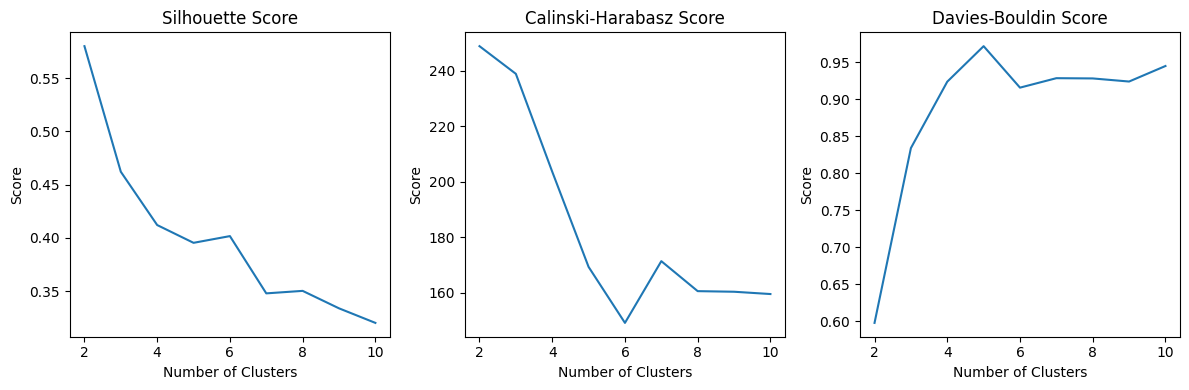

In [6]:
if __name__ == "__main__":
    evaluate_kmeans()
